# Autonomy fleet visualization

The objectives of this notebook are to :
<ol>
    <li> Download autonomy assets data </li>
    <li> Show the current location of autonomy assets </li>
    <li> Show the last profiles of the assets </li>
    <li> Show the full depth/time transect of the assets </li>
</ol>

To run this notebook please refer to the readme of the github page (https://github.com/NOC-OBG-Autonomy/biocarbon_nrt_data_viz).

## Download autonomy assets data

In [2]:
import pandas as pd
import numpy as np
import requests
import shutil
import os
import gzip
from pathlib import Path
import re
from tqdm import tqdm
from urllib.request import urlretrieve
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from datetime import datetime
from scipy import interpolate

We build the data repository structure. The data folder is not sync with git, so we need to create it if missing (i.e. first time your run this notebook on your computer).

In [2]:
def create_missing_directories():
    # Define the path to the parent directory
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

    # Check if 'data' folder exists in the parent directory
    data_dir = os.path.join(parent_dir, 'data')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print("'data' folder created in the parent directory.")
    else:
        print("'data' folder already exists in the parent directory.")

    # Check if 'floats' directory exists inside 'data' folder
    floats_dir = os.path.join(data_dir, 'Floats')
    if not os.path.exists(floats_dir):
        os.makedirs(floats_dir)
        print("'floats' directory created inside 'data' folder.")
    else:
        print("'floats' directory already exists inside 'data' folder.")

    # Check if 'gliders' directory exists inside 'data' folder
    gliders_dir = os.path.join(data_dir, 'Gliders')
    if not os.path.exists(gliders_dir):
        os.makedirs(gliders_dir)
        print("'gliders' directory created inside 'data' folder.")
    else:
        print("'gliders' directory already exists inside 'data' folder.")

if __name__ == "__main__":
    create_missing_directories()

'data' folder already exists in the parent directory.
'floats' directory already exists inside 'data' folder.
'gliders' directory already exists inside 'data' folder.


For now, we will visualize only test floats. One in the Icelandic bassin and the other in SO during the Custard cruise, which is a good test case as it has also gliders deployements.

We don't automate in this script the retrieving of downloading url for the sake of simplicity. 
You can keep in mind that the list of float data and their repertory are findable here : https://data-argo.ifremer.fr/argo_synthetic-profile_index.tx

In [5]:
wmo_list = [4903532, 1902637]
#Float 1 = test float in the Icelandic Bassin
float_1_url = 'https://data-argo.ifremer.fr/dac/aoml/4903532/4903532_Sprof.nc'
#Float 2 = test float on Custard with glider next to it
float_2_url = 'https://data-argo.ifremer.fr/dac/coriolis/1902637/1902637_Sprof.nc'

#List the floats
floats_url = [float_1_url, float_2_url]

#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
floats_dir =  os.path.join(parent_dir, 'Data/Floats')

#Create floats filename
floats_filenames = []
for i in floats_url:
    filename = floats_dir + '/' + i.rsplit('/', 1)[1]
    floats_filenames.append(filename)

In [6]:
#Download floats data. We do it everytime so we are sure to work with a DAC up to date version. 
#We could check with the synthetic profile index if it is needed to download a update.
for url, filename in zip(floats_url, floats_filenames):
    urlretrieve(url, filename)


## Plot BGC-Argo locations

### Icelandic Bassin float

In [7]:
print(wmo_list)

[4903532, 1902637]


In [17]:
position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})
for file, wmo in zip(floats_filenames, wmo_list):
    dat = xr.open_dataset(file)
    dat = dat.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    temp_df = dat[['LONGITUDE', 'LATITUDE', 'JULD']].to_dataframe().reset_index()
    temp_df['float'] = wmo
    position_df = pd.concat([position_df, temp_df], ignore_index=True)
    dat.close()

wmo = 4903532

C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\1814013463.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  position_df = pd.concat([position_df, temp_df], ignore_index=True)


Zoom on the Icelandic bassin

In [18]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

# Define data's extents I used an arbitrary extent that depicts the Icelandic Bassin
min_lon = -35
max_lon = -5
min_lat = 55
max_lat = 66


In [10]:
bath_directory = parent_dir + '/Data/' + "ne_10m_bathymetry_all/"
def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile

    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(bath_directory)

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob(bath_directory + '*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (min_lon - 3, max_lon + 3,min_lat - 1, max_lat + 1)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict

In [ ]:
depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')


C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\1511687579.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(formatted_date)


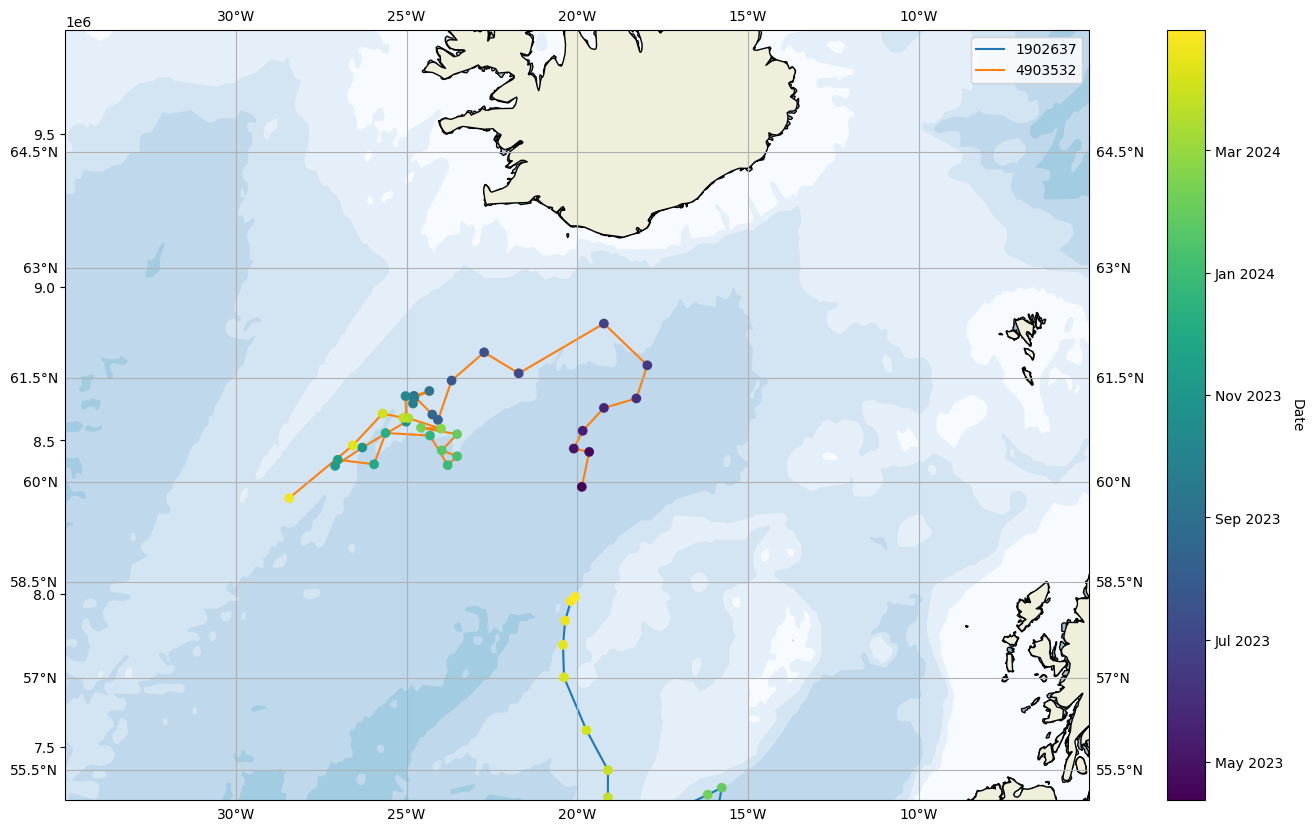

In [104]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib
grouped = position_df.groupby('float')

# Construct a discrete colormap with colors corresponding to each depth
depths = depths_str.astype(int)
N = len(depths)
nudge = 0.01  # shift bin edge slightly to include data
boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
norm = matplotlib.colors.BoundaryNorm(boundaries, N)
blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
colors_depths = blues_cm(norm(depths))

# Set up plot
# Initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1,
                    projection=ccrs.Mercator())

# Set the map extent based on your latitude and longitude ranges
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Scatter plot
sc = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = position_df['JULD'], zorder = 3)

#set the plot color bar
cbar = plt.colorbar(sc, ax = ax, label='Date')
cbar.set_label('Date', rotation=270, labelpad=15)

float_array = cbar.ax.get_yticks()
formatted_date = np.vectorize(lambda x: datetime.fromtimestamp(float(x) / 1e9).strftime("%b %Y"))(float_array)
cbar.ax.set_yticklabels(formatted_date)

for i, depth_str in enumerate(depths_str):
    ax.add_geometries(shp_dict[depth_str].geometries(),
                        crs=ccrs.PlateCarree(),
                        color=colors_depths[i])

for name, group in grouped:
    group.plot(x='LONGITUDE', y='LATITUDE', ax=ax, transform=ccrs.PlateCarree(), label=name, zorder=2)
# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(land_50m)
ax.stock_img()

# print a grid on it
gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())

# Convert vector bathymetries to raster (saves a lot of disk space)
# while leaving labels as vectors
ax.set_rasterized(True)


## Profile plotting

In [42]:
dat = xr.open_dataset(floats_filenames[0])
df = dat[['JULD', 'PRES_ADJUSTED', 'TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'CHLA_ADJUSTED', 'BBP700_ADJUSTED', 'DOXY_ADJUSTED']].to_dataframe()
dat.close()
df = df.reset_index().set_index('JULD', drop=False)

C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\1586087848.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(formatted_date)


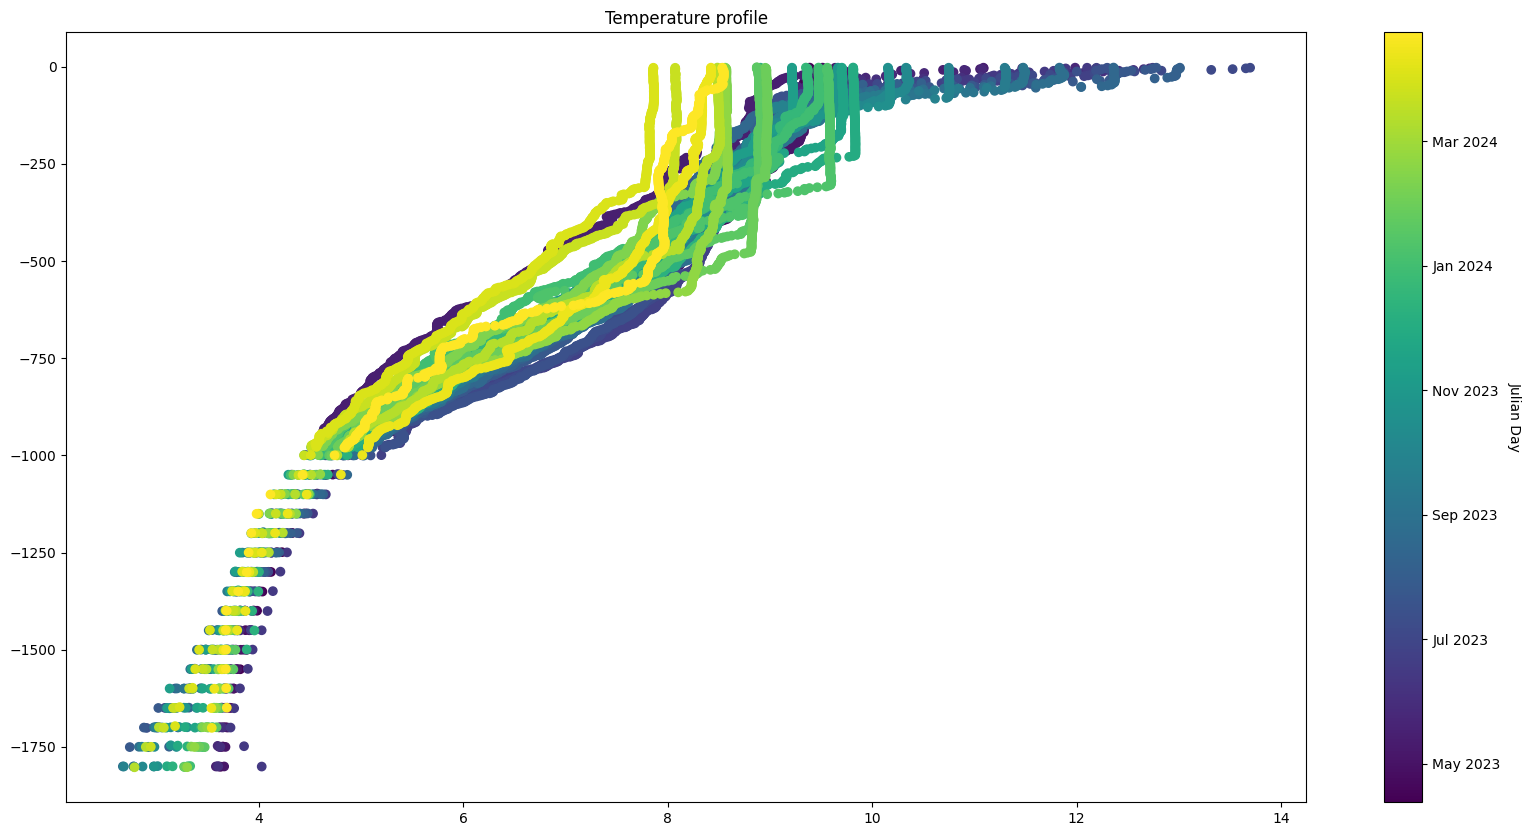

In [44]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc = ax.scatter( df['TEMP_ADJUSTED'], - (df['PRES_ADJUSTED']), c = df.index)

#set the plot color bar
cbar = plt.colorbar(sc, ax = ax, label='Julian day')
cbar.set_label('Julian Day', rotation=270, labelpad=15)

float_array = cbar.ax.get_yticks()
formatted_date = np.vectorize(lambda x: datetime.fromtimestamp(float(x) / 1e9).strftime("%b %Y"))(float_array)
cbar.ax.set_yticklabels(formatted_date)
# set the plot title
ax.set_title("Temperature profile")
plt.show()

In [80]:
import math
last_date = max(df['JULD'])

last_df = df[df['JULD'] == last_date]
early_df = df[df['JULD'] != last_date]
early_df = early_df[early_df['JULD'] > pd.to_datetime('2024-01-01')]

alphas = (early_df['N_PROF'] - min(early_df['N_PROF']))/(max(early_df['N_PROF']) - min(early_df['N_PROF']))

In [48]:
lastmonth_df = df[df['JULD'] > pd.to_datetime('2024-03-25')]

C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\3060189060.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(formatted_date)


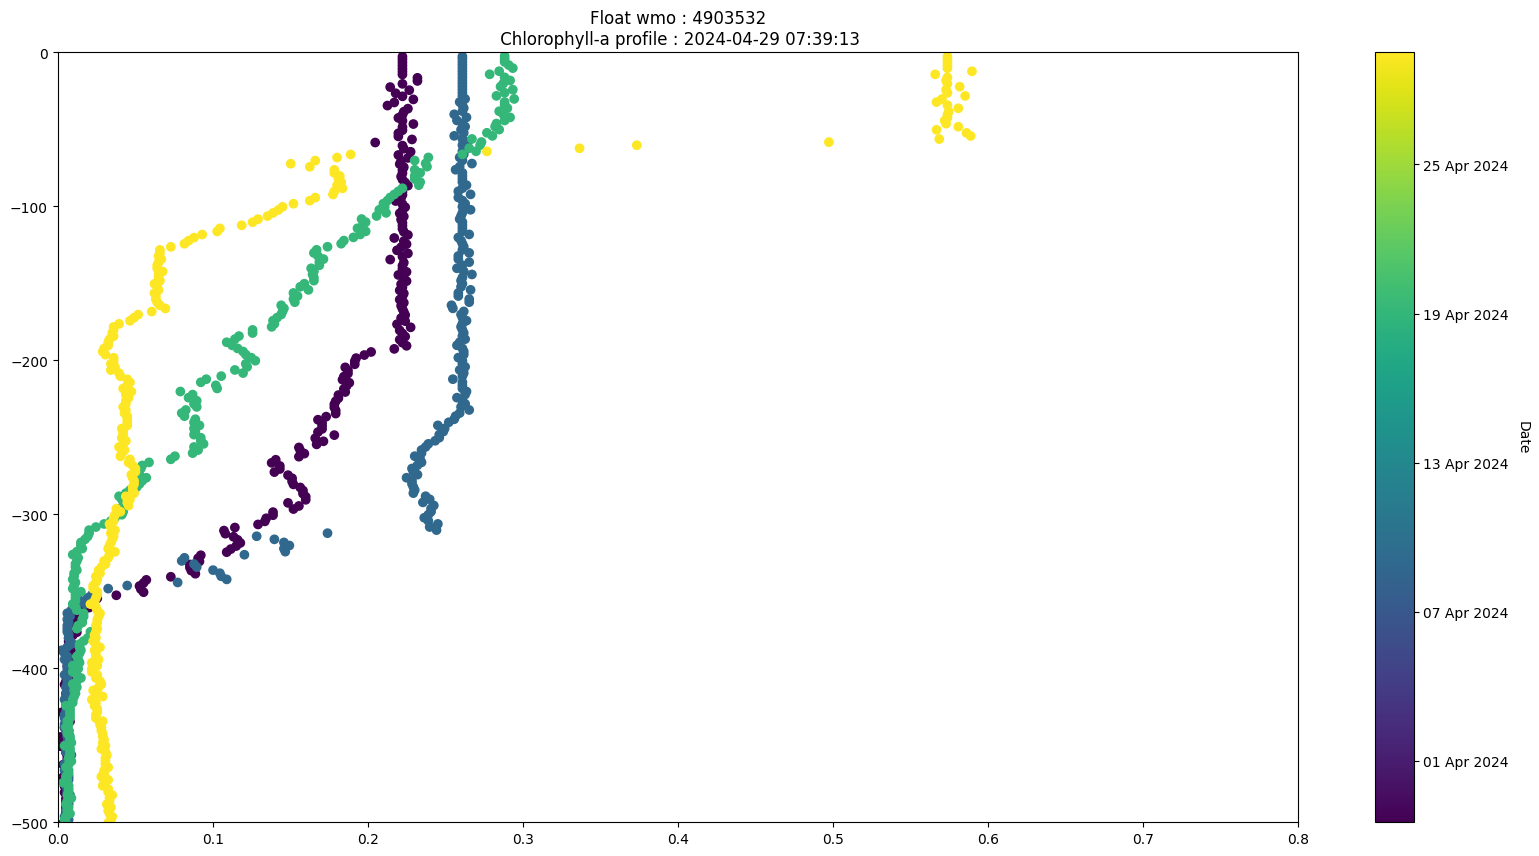

In [100]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc = ax.scatter( lastmonth_df['CHLA_ADJUSTED'], - (lastmonth_df['PRES_ADJUSTED']), c = lastmonth_df['JULD'])

#set the plot color bar
cbar = plt.colorbar(sc, ax = ax, label='Julian day')
cbar.set_label('Date', rotation=270, labelpad=15)
float_array = cbar.ax.get_yticks()
formatted_date = np.vectorize(lambda x: datetime.fromtimestamp(float(x) / 1e9).strftime("%d %b %Y"))(float_array)
cbar.ax.set_yticklabels(formatted_date)
ax.set_ylim([-500,0])
ax.set_xlim([0,0.8])
# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n Chlorophyll-a profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\2854441662.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(formatted_date)


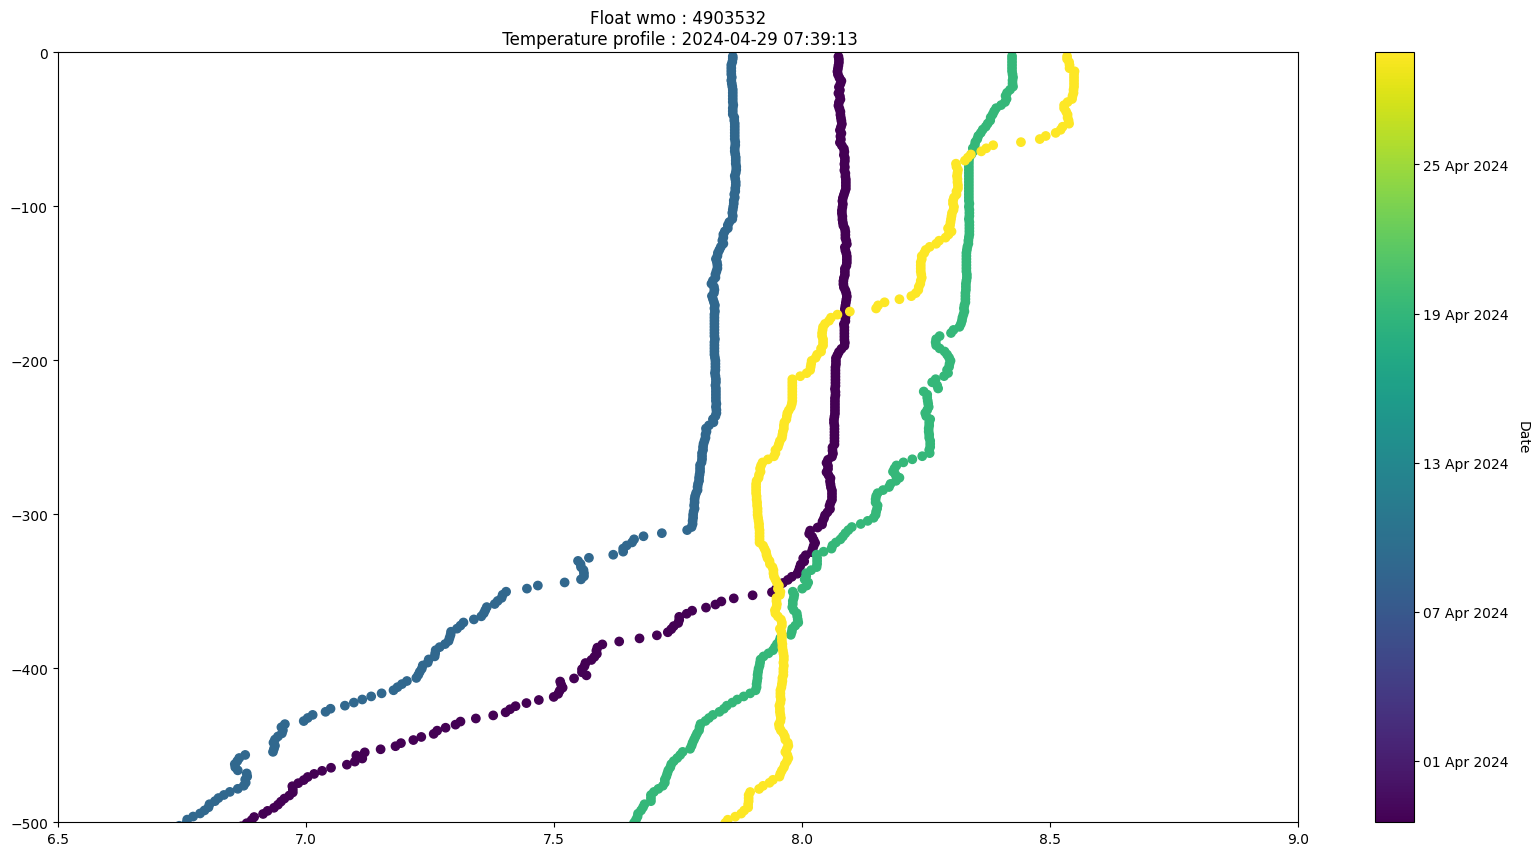

In [99]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc = ax.scatter( lastmonth_df['TEMP_ADJUSTED'], - (lastmonth_df['PRES_ADJUSTED']), c = lastmonth_df['JULD'])

#set the plot color bar
cbar = plt.colorbar(sc, ax = ax, label='Julian day')
cbar.set_label('Date', rotation=270, labelpad=15)
float_array = cbar.ax.get_yticks()
formatted_date = np.vectorize(lambda x: datetime.fromtimestamp(float(x) / 1e9).strftime("%d %b %Y"))(float_array)
cbar.ax.set_yticklabels(formatted_date)
ax.set_ylim([-500,0])
ax.set_xlim([6.5,9])
# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n Temperature profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

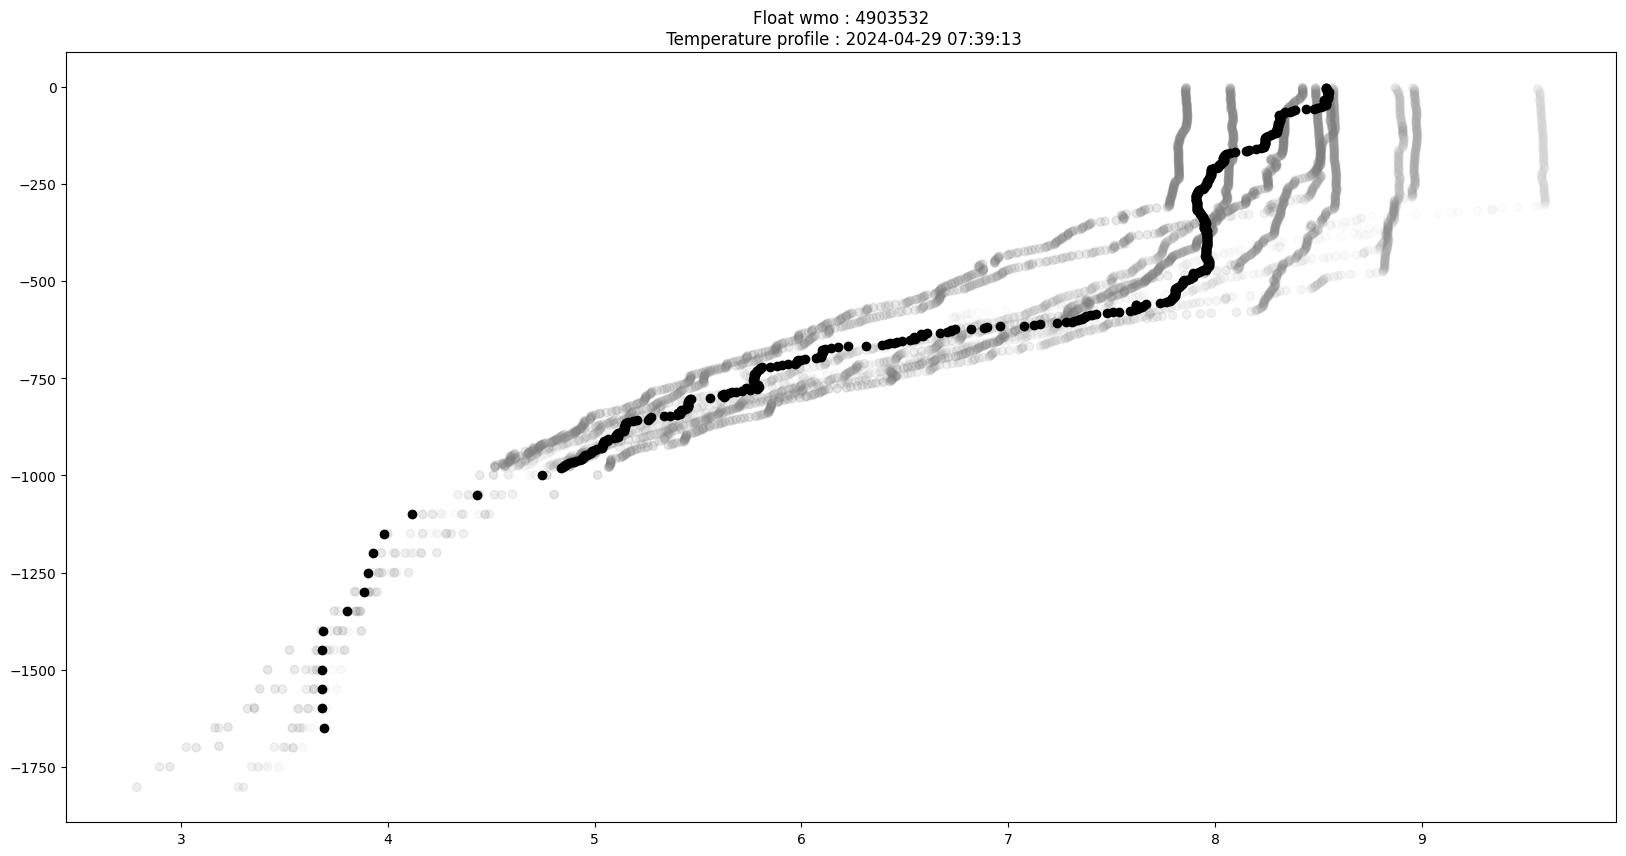

In [87]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['TEMP_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas/5, c = 'grey')
sc = ax.scatter( last_df['TEMP_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)

# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n Temperature profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

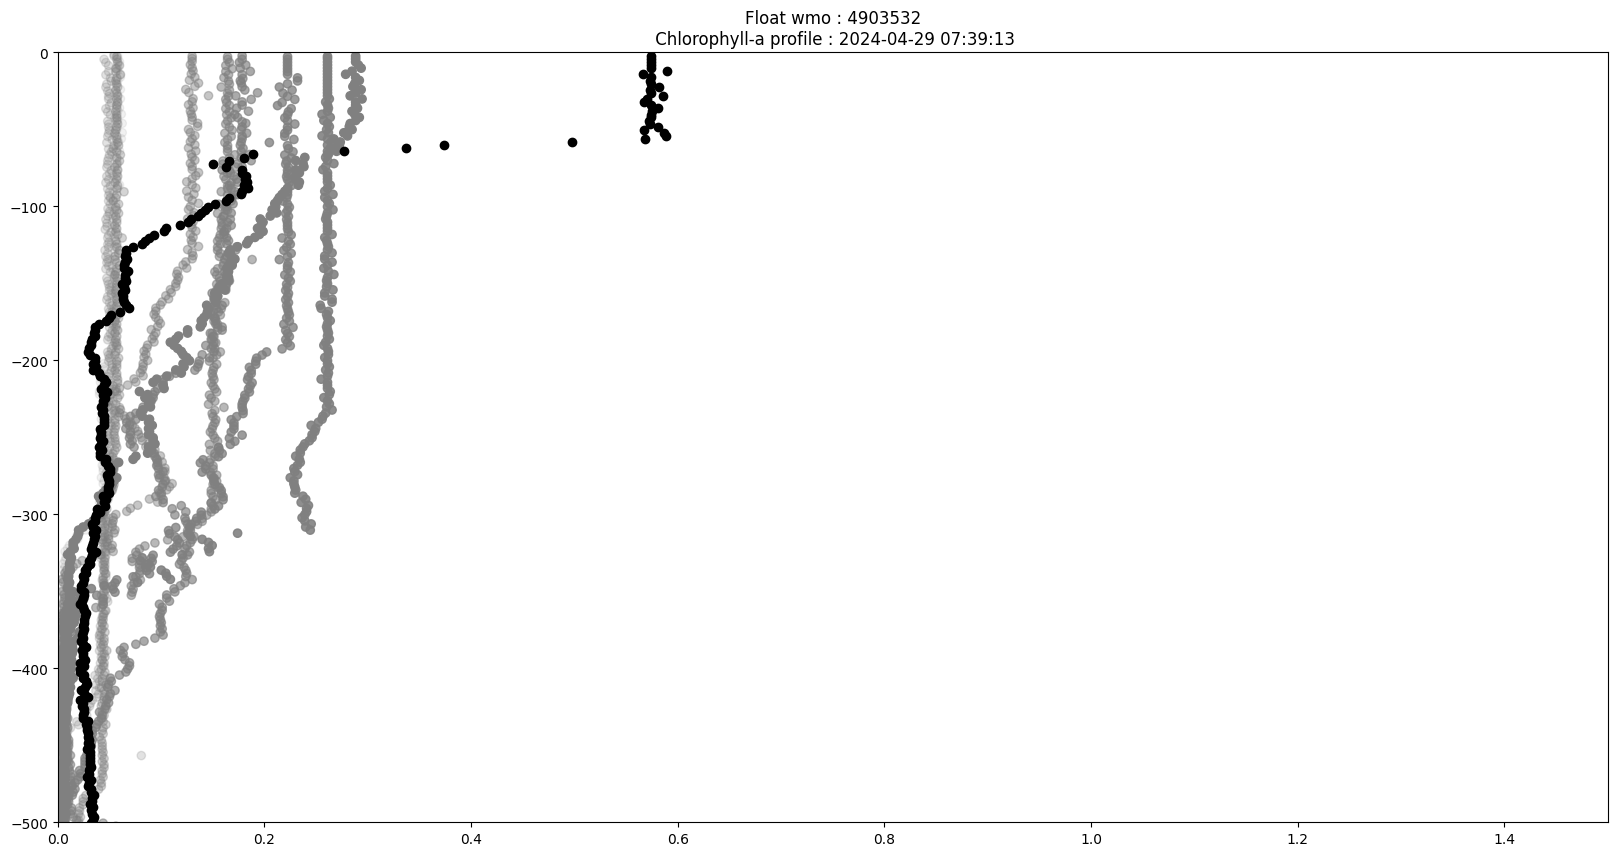

In [88]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['CHLA_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas, c = 'grey')
sc = ax.scatter( last_df['CHLA_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)
ax.set_ylim([-500,0])
ax.set_xlim([0,1.5])
# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n Chlorophyll-a profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

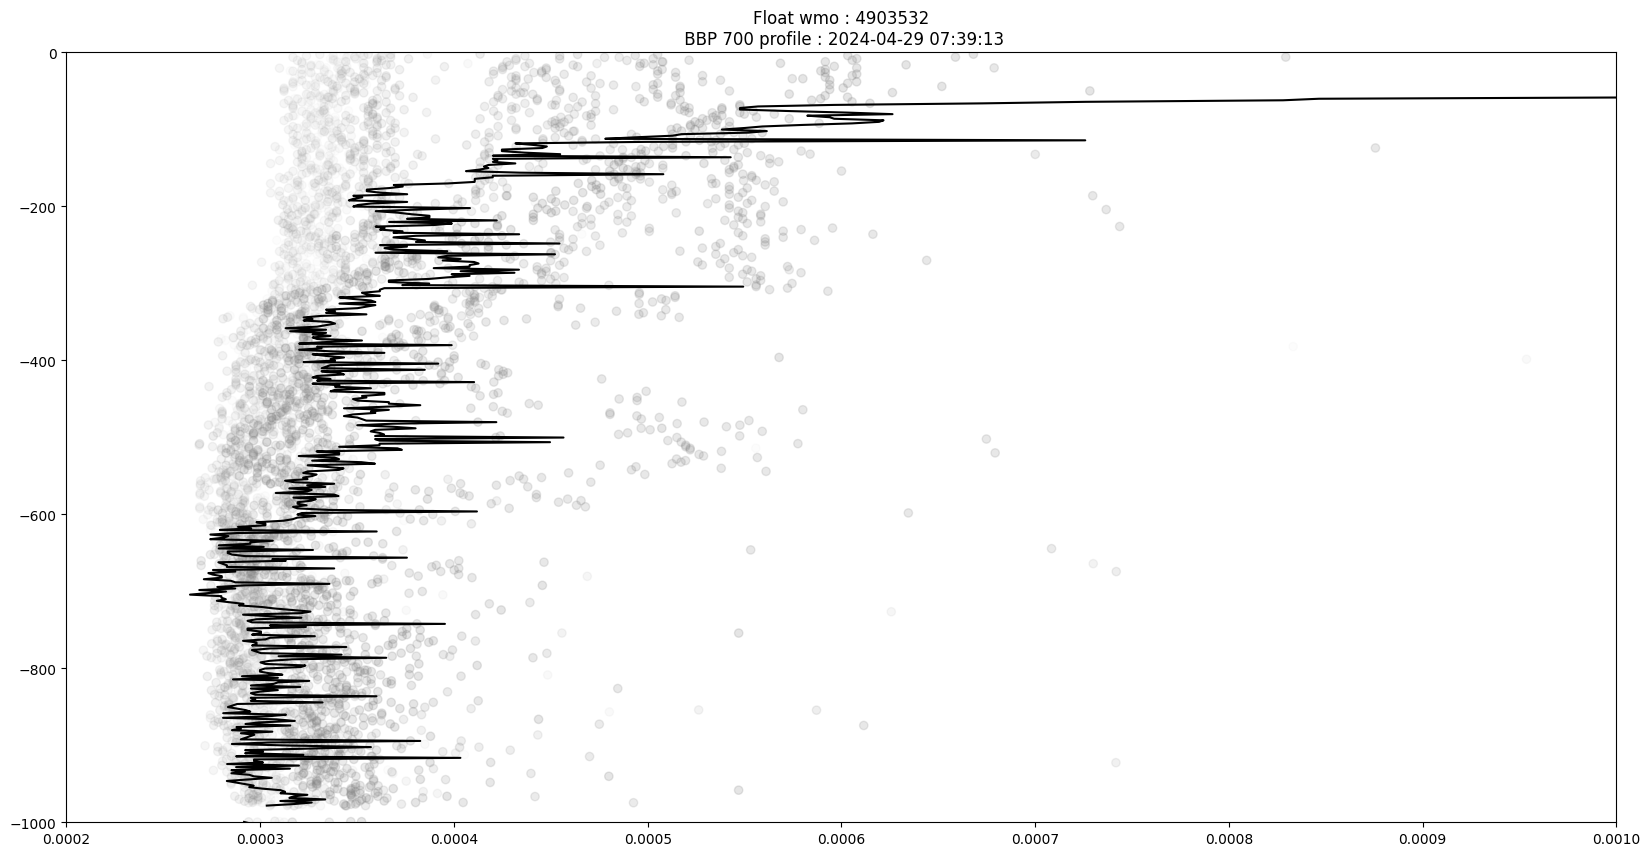

In [90]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['BBP700_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas/5, c = 'grey')
sc = ax.plot( last_df['BBP700_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)
ax.set_ylim([-1000,0])
ax.set_xlim([0.0002,0.001])
# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n BBP 700 profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

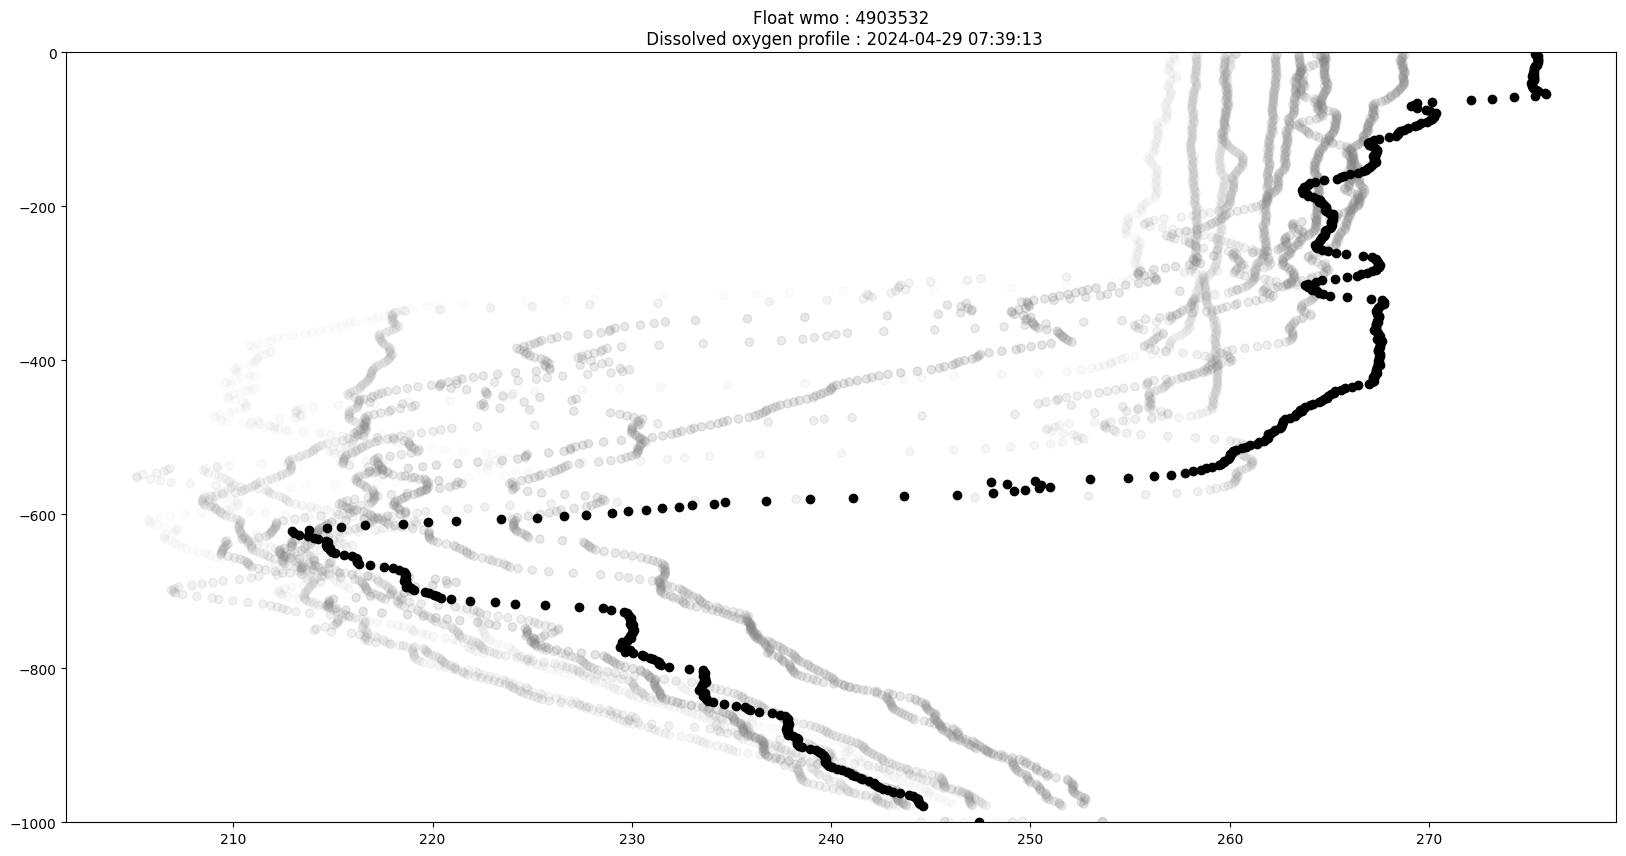

In [92]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['DOXY_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas/5, c = 'grey')
sc = ax.scatter( last_df['DOXY_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)
ax.set_ylim([-1000,0])
# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n Dissolved oxygen profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

## Transect of the float

In [95]:
data = xr.open_dataset(floats_filenames[0])
data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})

ValueError: Unsupported key-type <class 'xarray.core.dataarray.DataArray'>

C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\926815598.py:19: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA'].values,cmap=cmap)
C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\926815598.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label=cbar_label,extend=extend)
C:\Users\flapet\AppData\Local\Temp\ipykernel_19868\926815598.py:23: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit

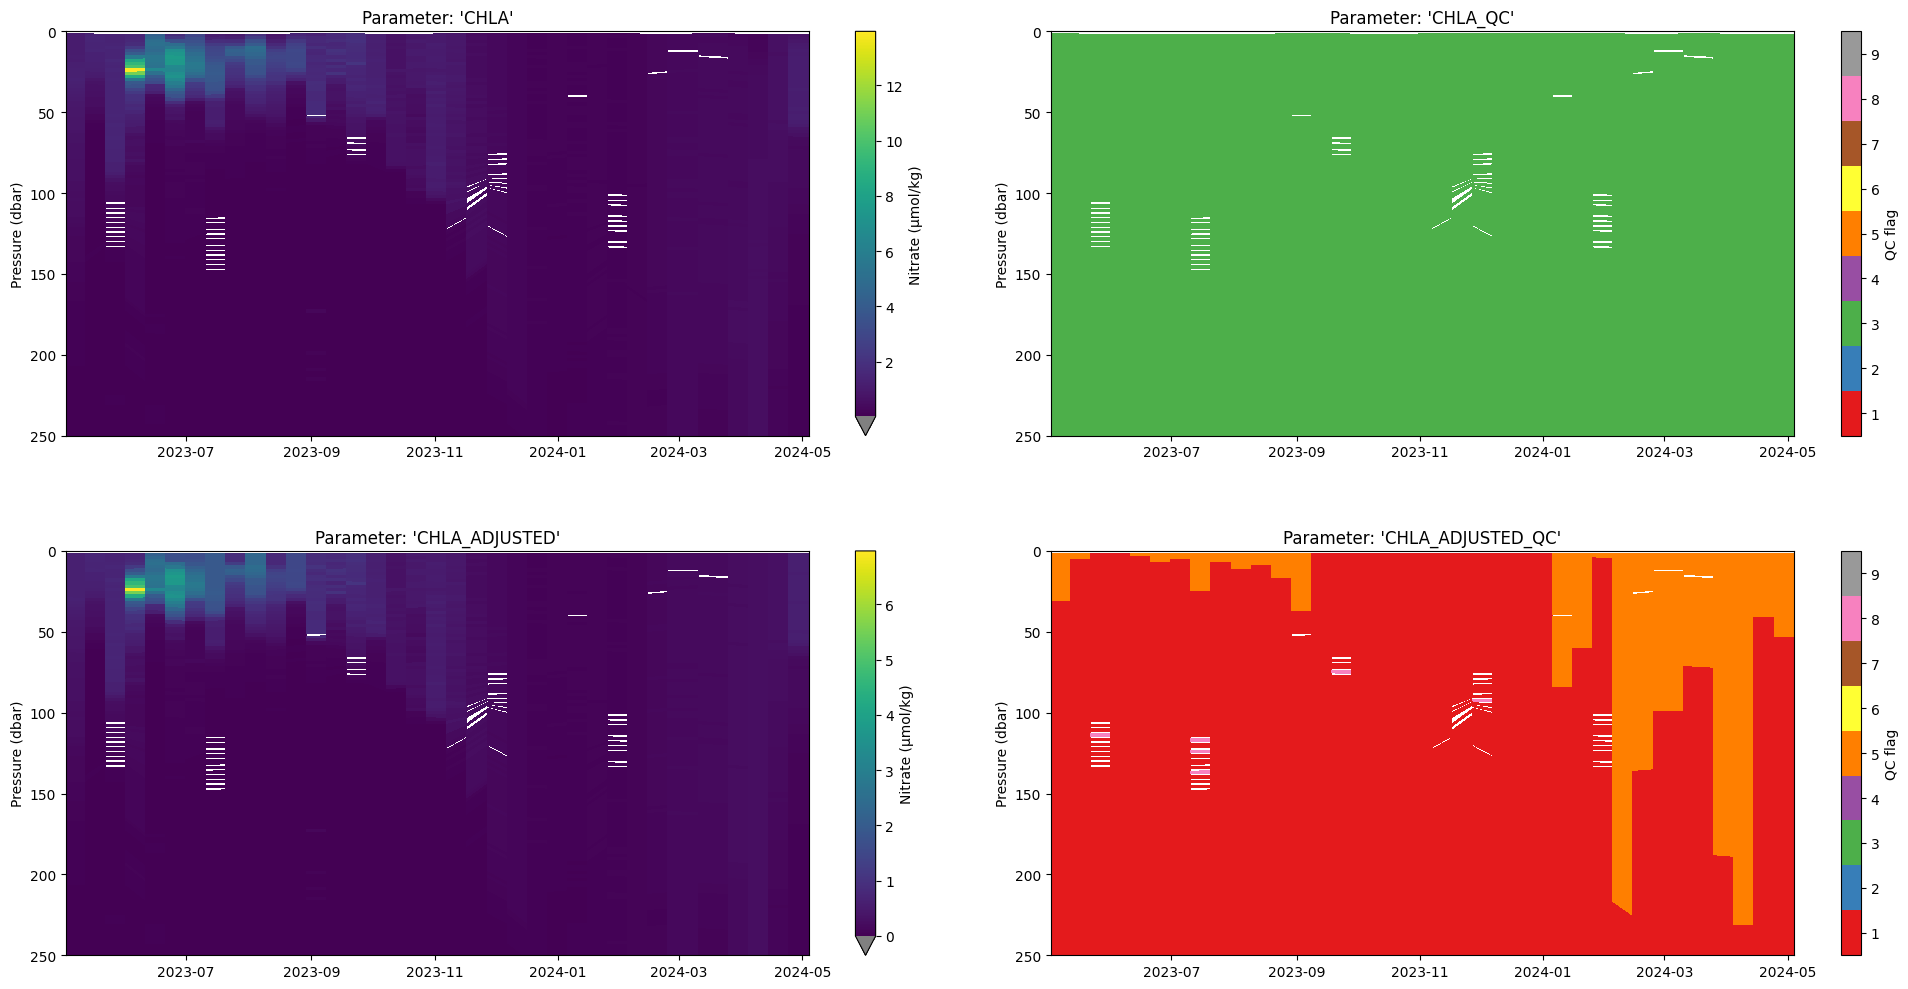

In [94]:
# Stack NumPy array of datetimes to create a 2D grid
time_2D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T

# Function for repetitive parts of plot
def config_depth_section(cbar_label,title):
  plt.ylim([0,250])
  plt.gca().invert_yaxis()
  plt.ylabel('Pressure (dbar)')
  if 'Nitrate' in cbar_label: extend = 'min'
  else:                       extend = 'neither'
  plt.colorbar(label=cbar_label,extend=extend)
  plt.title(title)

# Create subplots
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
cmap = plt.get_cmap('viridis')
cmap.set_under('0.5')
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA'].values,cmap=cmap)
config_depth_section('Nitrate (µmol/kg)',"Parameter: 'CHLA'")

plt.subplot(2,2,2)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'CHLA_QC'")

plt.subplot(2,2,3)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_ADJUSTED'].values,cmap=cmap)
config_depth_section('Nitrate (µmol/kg)',"Parameter: 'CHLA_ADJUSTED'")

plt.subplot(2,2,4)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_ADJUSTED_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'CHLA_ADJUSTED_QC'")

plt.tight_layout(h_pad=5,w_pad=3)
plt.show()

In [97]:
# Function to convert an array from NumPy datetime64 to Python float format
def datetime_to_float(dt):
  return (dt - np.datetime64('1900-01-01')) / np.timedelta64(1,'D')

# Function to convert an array from Python float to NumPy datetime64 format
def float_to_datetime(nums):
  return (nums * np.timedelta64(1,'D')) + np.datetime64('1900-01-01')

# Function to interpolate data from a specified float parameter to a uniform time and pressure grid
def interpolate_depth_section(param_name,specify_qc_flags=None,pres_interval=1.0):
  """
  Arguments:
      param_name: string with netCDF file parameter name (e.g., 'TEMP_ADJUSTED') to interpolate
      specify_qc_flags: None to ignore QC flags
                        or a list of QC flags (e.g., [1,2,3]) indicating which data to retain before interpolation
      pres_interval: vertical resolution for interpolating pressure (z) axis (default: 1.0 dbar)
  
  Returns:
      time_coord: 1-D NumPy array with original profile timestamps in np.datetime64 format
      pres_coord: 1-D NumPy array with a uniform pressure (z) coordinate from 0 dbar to the deepest recorded
                  pressure value, at a resolution of <pres_interval> dbar
      time_grid: 2-D NumPy array with the meshed grid of time_coord
      pres_grid: 2-D NumPy array with the meshed grid of pres_coord
      param_gridded: 2-D NumPy array with the interpolated parameter values at the locations of time_grid and pres_grid

  """

  # New grid points
  time_coord = data['JULD'].values
  pres_coord = np.arange(0,data['PRES'].max(),pres_interval)
  time_grid, pres_grid = np.meshgrid(time_coord,pres_coord)
  time_grid = datetime_to_float(time_grid)     # Convert from np.datetime64 to float

  # 1-D (flattened) versions of old grids and parameter values
  time_1D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T.flatten()
  pres_1D = data['PRES'].values.flatten()
  param_1D = data[param_name].values.flatten()
  if param_1D.dtype == object:         # If parameter is an array of QC flag data
    param_1D = param_1D.astype(float)  # Convert QC flags from dtype 'object' to float
    interp_method = 'nearest'          # Use nearest-neighbor interpolation for QC flags to avoid unwanted averaging
  else:
    interp_method = 'linear'           # Use bilinear interpolation for normal data fields

  # Extract only values matching specified QC flags
  if specify_qc_flags is not None:
    qc_1D = data[param_name + '_QC'].values.astype(float).flatten()
    qc_mask = np.tile(False,len(qc_1D))
    for qc_flag in specify_qc_flags:
      qc_mask = np.logical_or(qc_mask,qc_1D == qc_flag)
    time_1D = time_1D[qc_mask]
    pres_1D = pres_1D[qc_mask]
    param_1D = param_1D[qc_mask]

  # Remove NaN values before interpolation
  time_1D = datetime_to_float(time_1D[~np.isnan(param_1D)])       # Convert from np.datetime64 to float
  pres_1D = pres_1D[~np.isnan(param_1D)]
  param_1D = param_1D[~np.isnan(param_1D)]

  # Interpolate from irregular points to grid
  param_gridded = interpolate.griddata((time_1D,pres_1D),param_1D,(time_grid,pres_grid),method=interp_method)

  # Return coordinates, grid, and gridded data
  return time_coord, pres_coord, float_to_datetime(time_grid), pres_grid, param_gridded

Text(0.5, 1.0, 'Particle backscattering at 700 nanometers')

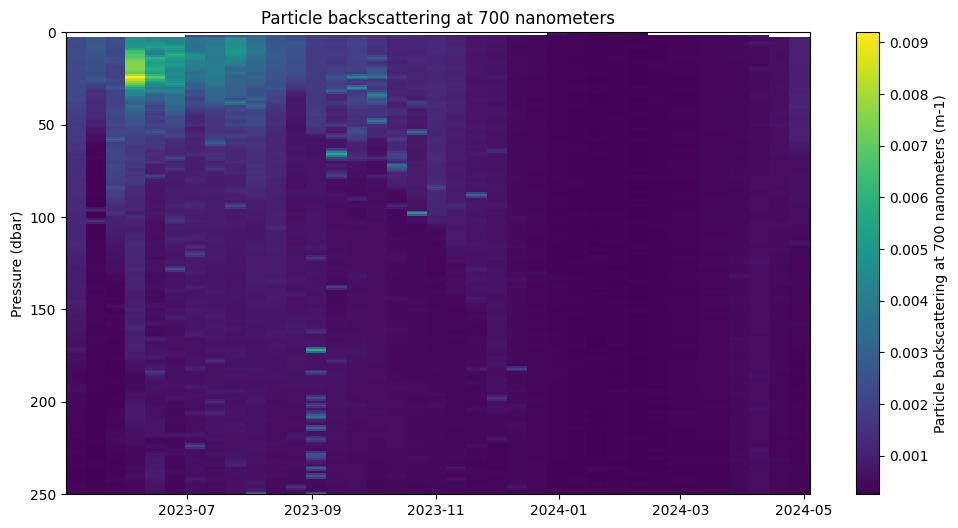

In [98]:
# Interpolate data
param_name = 'BBP700_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name)

Text(0.5, 1.0, 'Sea temperature in-situ ITS-90 scale')

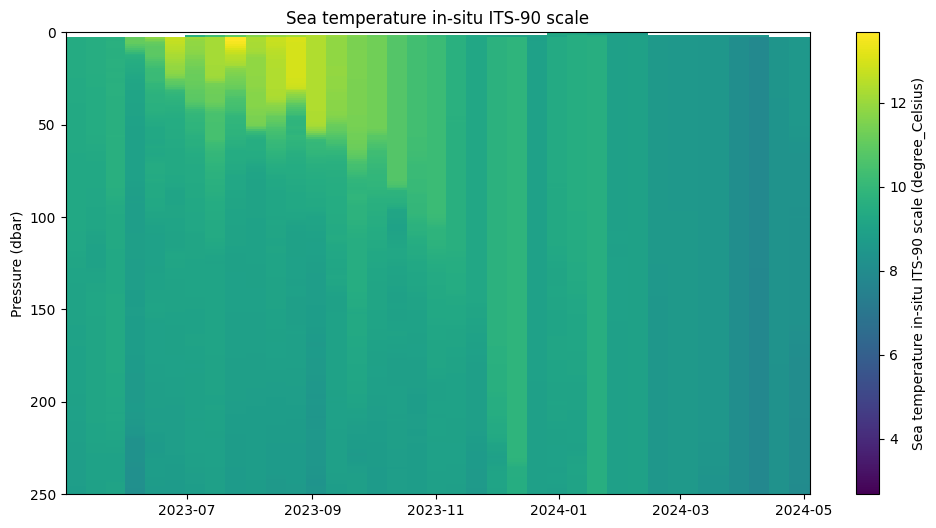

In [ ]:
# Interpolate data
param_name = 'TEMP_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name)

Text(0.5, 1.0, 'Chlorophyll-A')

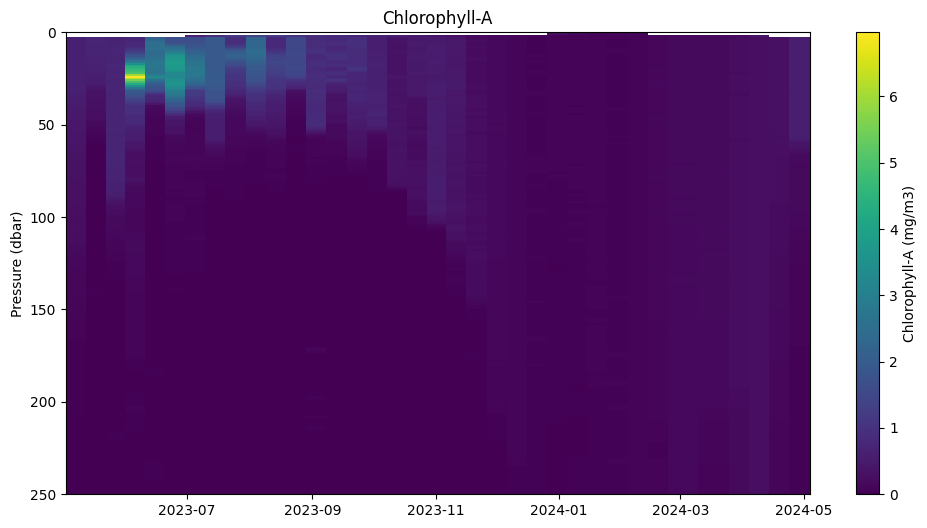

In [ ]:
# Interpolate data
param_name = 'CHLA_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name)

Text(0.5, 1.0, 'Dissolved oxygen')

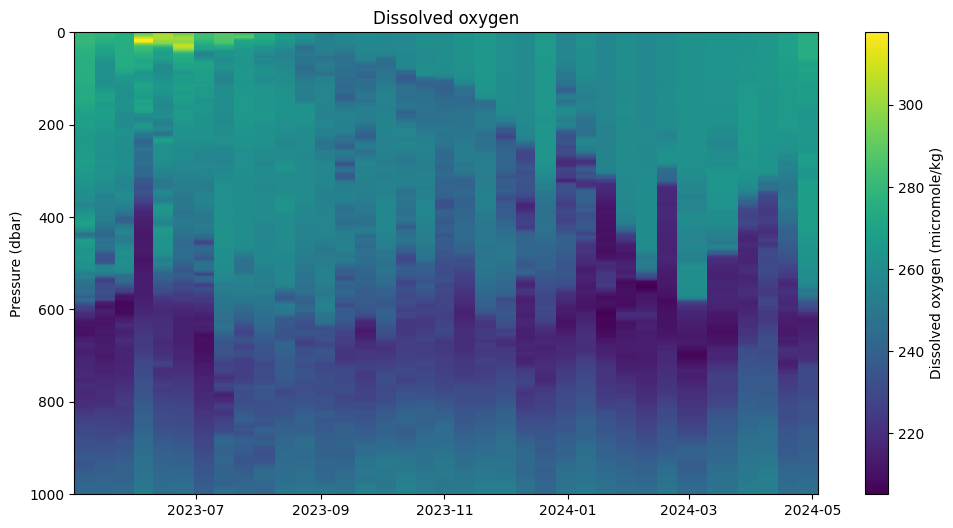

In [ ]:
# Interpolate data
param_name = 'DOXY_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name)